In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

In [2]:
data = pd.read_csv("combined_data_with_sentiment.csv")
data.head()

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating,cleaned_reviews,avg_rating,review_count,normalized_rating,normalized_review_count,sentiment_score,predicted_sentiment
0,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,This is an extremely basic course. Machine lea...,By Deleted A,2017-03-18,1,extremely basic course machine learning built ...,4.750522,35895,0.277835,2.014232,-0.1590,-1
1,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,The course is ok but the certification procedu...,By Bruno C,2015-11-09,1,course ok certification procedure messno state...,4.750522,35895,0.277835,2.014232,0.3612,1
2,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,"I just started week 3 , I have to admit that I...",By Fadi,2019-04-15,1,started week admit good course explaining idea...,4.750522,35895,0.277835,2.014232,0.8360,1
3,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,This course is absolute garbage. You get no f...,By Mathew L,2015-09-25,1,course absolute garbage get feedback quiz assi...,4.750522,35895,0.277835,2.014232,-0.4936,-1
4,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,"However good the material and lectures may be,...",By Rui C,2015-12-12,1,however good material lecture may use outdated...,4.750522,35895,0.277835,2.014232,0.5859,1


In [3]:
# Drop rows with NaN values in 'cleaned_reviews'
data = data.dropna(subset=['cleaned_reviews'])

# Clustering

Cluster Distribution:
cluster
0    27709
1    14210
4    13188
2    12122
3     4829
Name: count, dtype: int64

Top terms in each cluster:

Cluster 0:
  able
  absolutely

Cluster 1:
  able
  absolutely

Cluster 2:
  absolutely
  able

Cluster 3:
  able
  absolutely

Cluster 4:
  able
  absolutely


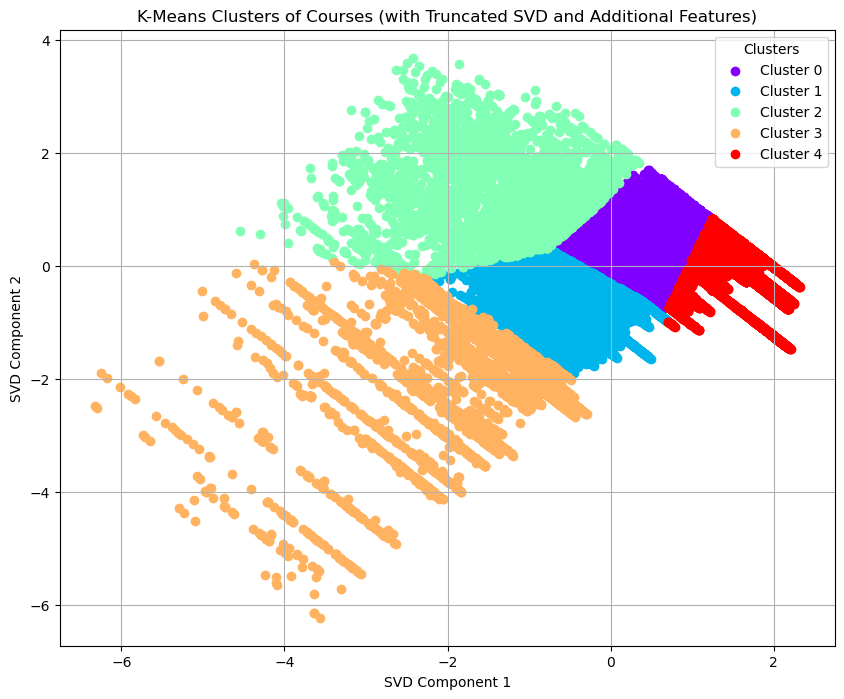

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 1. Reduce the data size by sampling 1% of the combined data
df = data
sampled_df = df.sample(frac=0.05, random_state=42)

# 2. Initialize the TF-IDF vectorizer with unigrams and a maximum of 500 features
vectorizer = TfidfVectorizer(stop_words='english', max_features=500, ngram_range=(1, 1))

# 3. Create the sparse TF-IDF matrix
tfidf_matrix = vectorizer.fit_transform(sampled_df['cleaned_reviews'])

# 4. Combine numerical features (normalized_rating, normalized_review_count, sentiment_score)
numerical_features = ['normalized_rating', 'normalized_review_count', 'sentiment_score']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(sampled_df[numerical_features])

# Combine the numerical features with the TF-IDF matrix
from scipy.sparse import hstack
combined_features = hstack([scaled_features, tfidf_matrix])

# 5. Apply Truncated SVD for dimensionality reduction (to 2 components for visualization)
n_components = 2  # Choose the number of dimensions for visualization
svd = TruncatedSVD(n_components=n_components, random_state=42)
reduced_features = svd.fit_transform(combined_features)

# 6. Apply KMeans clustering to the reduced features
optimal_clusters = 5  # Based on previous analysis or assumptions
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(reduced_features)

# 7. Add the cluster labels to the sampled DataFrame
sampled_df['cluster'] = kmeans.labels_

# 8. Check the number of instances in each cluster
print("Cluster Distribution:")
print(sampled_df['cluster'].value_counts())

# 9. Print top terms for each cluster based on the cluster centers
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

print("\nTop terms in each cluster:")
for i in range(optimal_clusters):
    print(f"\nCluster {i}:")
    for ind in order_centroids[i, :10]:  # Print the top 10 terms for each cluster
        print(f"  {terms[ind]}")

# 10. Generate colors for the visualization
colors = plt.cm.rainbow(np.linspace(0, 1, optimal_clusters))

# 11. Create a scatter plot to visualize the clusters
plt.figure(figsize=(10, 8))
for i in range(optimal_clusters):
    cluster_points = reduced_features[sampled_df['cluster'] == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[i], label=f'Cluster {i}')

plt.title('K-Means Clusters of Courses (with Truncated SVD and Additional Features)')
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.legend(title="Clusters")
plt.grid(True)
plt.show()

In [5]:
# Check courses inside each cluster
for cluster in range(optimal_clusters):
    print(f"\n=== Courses in Cluster {cluster} ===")
    cluster_courses = sampled_df[sampled_df['cluster'] == cluster]
    print(cluster_courses[['name', 'institution', 'avg_rating', 'review_count', 'sentiment_score']].head(10))  # Display first 10 courses
    print(f"\nTotal Courses in Cluster {cluster}: {len(cluster_courses)}")



=== Courses in Cluster 0 ===
                                                      name  \
228833                   Neural Networks and Deep Learning   
381453   Google Cloud Platform Fundamentals: Core Infra...   
402037                              Python Data Structures   
752193   IT Security: Defense against the digital dark ...   
747718                                      Cryptography I   
672112                     Using Python to Access Web Data   
1052901          Introduction to Data Analysis Using Excel   
1178997                    Understanding Financial Markets   
1071661         Teach English Now! Foundational Principles   
721490                        Marketing in a Digital World   

                                        institution  avg_rating  review_count  \
228833                              DeepLearning.AI    4.775994         35749   
381453                                 Google Cloud    4.717033         17419   
402037                       University of M

Cluster 2 could be identified as courses that users didn’t enjoy based on predominantly negative sentiment scores. These may not be recommended unless they are niche or critical.

Cluster 4, with high ratings and positive sentiment, contains courses that should be prioritized for recommendations.
User-Specific Recommendations:

If a user prefers courses with high average ratings, recommend from Cluster 4.

For users looking for specific technical topics (e.g., deep learning), use clusters like Cluster 0 and Cluster 1, which have focused but slightly varied content.

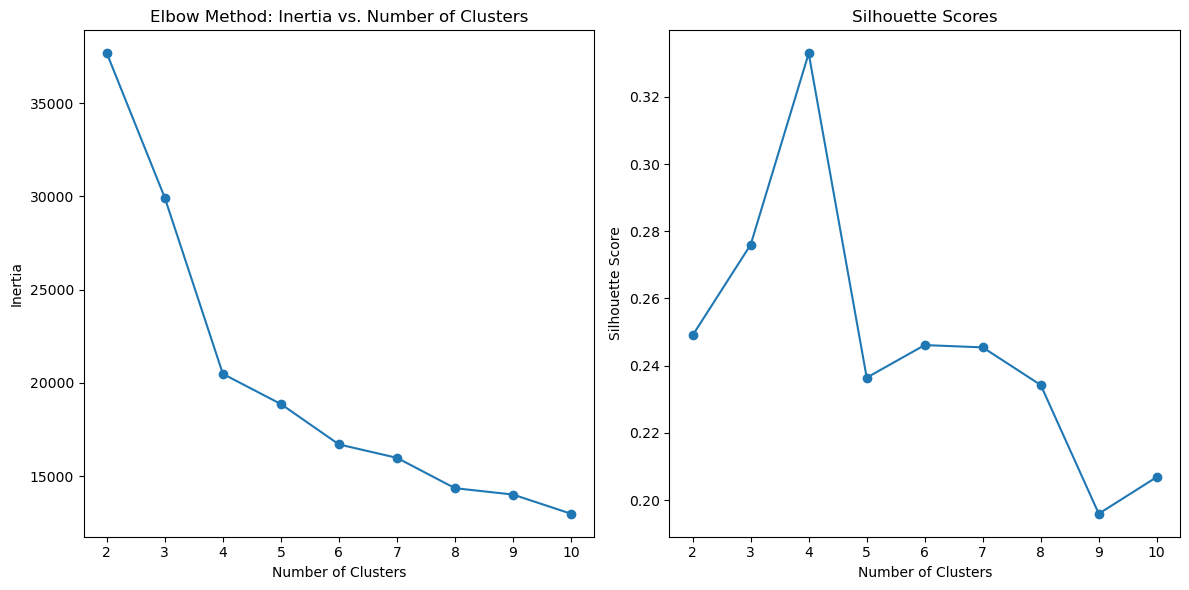

Optimal Number of Clusters: 4

=== Cluster 0 ===
                                                      name  avg_rating  \
647058                        The Data Scientist’s Toolbox    4.490537   
1137875             Gestión Empresarial Exitosa para Pymes    4.854510   
252698                               What is Data Science?    4.632612   
1175823                           Programming Fundamentals    4.651638   
747875                                      Cryptography I    4.774143   
1352484  Population Health During A Pandemic: Contact T...    4.796610   
1372128                Gestión de organizaciones efectivas    4.783569   
201463                              Crash Course on Python    4.734440   
249982                               What is Data Science?    4.632612   
814505                           Data Analysis with Python    4.457589   

         review_count  sentiment_score  
647058          17595           0.0516  
1137875          4124           0.0000  
252698       

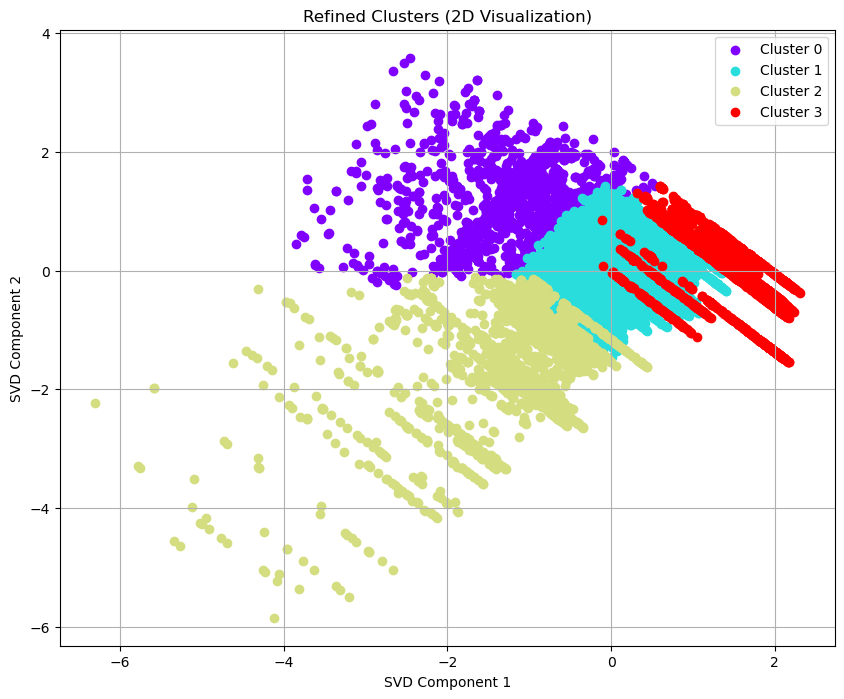

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.sparse import hstack

# 1. Sample the data for efficiency
sampled_df = df.sample(frac=0.01, random_state=42)

# 2. Feature Engineering
# Text-based features using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=500, ngram_range=(1, 2))
tfidf_matrix = vectorizer.fit_transform(sampled_df['cleaned_reviews'])

# Numerical features (normalize them)
numerical_features = ['avg_rating', 'review_count', 'sentiment_score']
scaler = StandardScaler()
scaled_numerical_features = scaler.fit_transform(sampled_df[numerical_features])

# Combine text and numerical features
combined_features = hstack([scaled_numerical_features, tfidf_matrix])

# 3. Dimensionality Reduction with Truncated SVD
n_components = 50  # Use higher dimensions for better clustering, visualize later
svd = TruncatedSVD(n_components=n_components, random_state=42)
reduced_features = svd.fit_transform(combined_features)

# 4. Determine Optimal Clusters with Silhouette Score
sil_scores = []
inertia = []
for k in range(2, 11):  # Testing for 2 to 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced_features)
    sil_scores.append(silhouette_score(reduced_features, kmeans.labels_))
    inertia.append(kmeans.inertia_)

# Plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method: Inertia vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), sil_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# 5. Apply KMeans with Optimal Clusters
optimal_clusters = sil_scores.index(max(sil_scores)) + 2  # Add 2 because range starts at 2
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
sampled_df['cluster'] = kmeans.fit_predict(reduced_features)

# 6. Analyze the Clusters
print(f"Optimal Number of Clusters: {optimal_clusters}")
for cluster in range(optimal_clusters):
    print(f"\n=== Cluster {cluster} ===")
    cluster_courses = sampled_df[sampled_df['cluster'] == cluster]
    print(cluster_courses[['name', 'avg_rating', 'review_count', 'sentiment_score']].head(10))
    print(f"Total Courses in Cluster {cluster}: {len(cluster_courses)}")

# 7. Visualize Clusters in 2D (Optional for validation)
svd_2d = TruncatedSVD(n_components=2, random_state=42)
features_2d = svd_2d.fit_transform(combined_features)

colors = plt.cm.rainbow(np.linspace(0, 1, optimal_clusters))
plt.figure(figsize=(10, 8))
for cluster in range(optimal_clusters):
    cluster_points = features_2d[sampled_df['cluster'] == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}', color=colors[cluster])

plt.title('Refined Clusters (2D Visualization)')
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.legend()
plt.grid(True)
plt.show()

Cluster 0:

Predominantly negative sentiment (sentiment_score around -1.5876).
Includes courses like "Cryptography I" and "What is Data Science?" despite decent ratings and review counts.
Likely captures courses with challenging or polarizing content or courses where the majority of reviews were negative.
Avoid recommending these courses unless a user specifically seeks such content or their preferences align with the challenges highlighted by reviewers.

Cluster 1:

Balanced cluster with positive sentiment, moderate to high ratings, and varied review counts.
Includes courses like "Google Cloud Platform Fundamentals" and "Marketing in a Digital World."
Likely represents popular, well-regarded courses with mixed content coverage (technical, business, etc.).
These courses are good candidates for general recommendations, especially for users interested in high-quality and practical topics.

Cluster 2:

A mix of moderate ratings, smaller review counts, and varied sentiment scores.
Includes courses like "Mastering Data Analysis in Excel" and "Data Science Methodology."
Likely captures less mainstream or niche courses that appeal to specific audiences.
Recommend these to users looking for specialized or less common topics. These courses might appeal to users with specific interests.

Cluster 3:

Highly-rated courses with significant review counts and neutral-to-positive sentiment.
Includes "Neural Networks and Deep Learning," "Learning How to Learn," and "Python Data Structures."
Likely captures top-performing, highly popular courses with broad appeal.
Prioritize these courses for recommendations, especially for new users or those exploring general topics with a strong reputation.


# Content-Based Filtering

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# 1. Aggregate data by course name
aggregated_df = sampled_df.groupby('name').agg({
    'institution': 'first',  # Use the first value for institution
    'cleaned_reviews': ' '.join,  # Concatenate all reviews for the course
    'avg_rating': 'mean',  # Take the average rating
    'review_count': 'sum',  # Sum up the review counts
    'sentiment_score': 'mean'  # Take the mean sentiment score
}).reset_index()

# Create a combined features column for similarity computation
aggregated_df['combined_features'] = aggregated_df['name'] + " " + aggregated_df['cleaned_reviews']

# 2. Compute TF-IDF Matrix
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = vectorizer.fit_transform(aggregated_df['combined_features'])

# 3. Compute Cosine Similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# 4. Recommend Courses Based on Similarity
def recommend_courses(course_name, cosine_sim=cosine_sim, df=aggregated_df, top_n=5):
    """
    Recommend top_n most similar courses to the given course_name based on cosine similarity.
    """
    # Find the index of the course
    try:
        idx = df[df['name'] == course_name].index[0]
    except IndexError:
        return f"Course '{course_name}' not found in the dataset."
    
    # Get similarity scores for all courses
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort courses by similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the indices of the top_n most similar courses (excluding the course itself)
    sim_indices = [i[0] for i in sim_scores[1:top_n + 1]]
    
    # Return the top_n courses
    return df.iloc[sim_indices][['name', 'institution', 'avg_rating', 'review_count', 'sentiment_score']]

# 5. Example Usage
# Recommend similar courses for a specific course
course_name = "Neural Networks and Deep Learning"
recommended_courses = recommend_courses(course_name, top_n=5)

# Display Recommendations
if isinstance(recommended_courses, str):
    print(recommended_courses)
else:
    print(f"Courses similar to '{course_name}':")
    print(recommended_courses)

Courses similar to 'Neural Networks and Deep Learning':
                                                  name          institution  \
455                                    Sequence Models      DeepLearning.AI   
243  Improving Deep Neural Networks: Hyperparameter...      DeepLearning.AI   
346                                   Machine Learning  Stanford University   
79         Convolutional Neural Networks in TensorFlow      DeepLearning.AI   
475              Structuring Machine Learning Projects      DeepLearning.AI   

     avg_rating  review_count  sentiment_score  
455    4.638550        727146         0.537198  
243    4.818824       3266550         0.576104  
346    4.750522      13029885         0.753879  
79     4.468628         55464         0.498471  
475    4.711857       2287200         0.479682  


For the course "Neural Networks and Deep Learning", the recommendations include:

Sequence Models:
Part of the same domain (machine learning/deep learning).
From the same institution (DeepLearning.AI), likely targeting users interested in similar advanced topics.

Improving Deep Neural Networks: Hyperparameter Tuning:
A highly-rated and well-reviewed course, relevant for users working on deep learning optimization.

Machine Learning:
A foundational course from Stanford University, appealing to users interested in the broader field of machine learning.

Convolutional Neural Networks in TensorFlow:
Relevant for users wanting to dive deeper into practical applications of deep learning with TensorFlow.

Structuring Machine Learning Projects:
Practical course for users aiming to build and deploy machine learning systems, aligned with the user's interest in deep learning.

Recommendations are clearly aligned with the course topic (deep learning and machine learning).

Courses are from similar institutions and instructors, ensuring consistent quality.

The recommendations include a mix of foundational and advanced courses (e.g., "Machine Learning" vs. "Sequence Models").

Courses have high avg_rating and review_count, indicating popularity and reliability.

# Hybrid Recommendation System

In [8]:
from sklearn.cluster import KMeans

# Step 1: Normalize Numerical Features
scaler = StandardScaler()
numerical_features = ['avg_rating', 'sentiment_score', 'review_count']
scaled_numerical_features = scaler.fit_transform(aggregated_df[numerical_features])

# Step 2: Combine Text and Numerical Features
combined_features = hstack([scaled_numerical_features, tfidf_matrix])

# Step 3: Recompute Clustering
# Choose the optimal number of clusters based on previous analysis
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
aggregated_df['cluster'] = kmeans.fit_predict(combined_features)

# Step 4: Compute Cosine Similarity on Combined Features
cosine_sim_combined = cosine_similarity(combined_features, combined_features)

# Step 5: Hybrid Recommendation System
def recommend_courses_hybrid(course_name, top_n=5, df=aggregated_df, sim_matrix=cosine_sim_combined):
    """
    Recommend top_n similar courses within the same cluster as the given course.
    """
    try:
        # Find the index and cluster of the target course
        idx = df[df['name'] == course_name].index[0]
        target_cluster = df.loc[idx, 'cluster']
        
        # Get similarity scores for all courses
        sim_scores = list(enumerate(sim_matrix[idx]))
        
        # Filter courses by the same cluster
        same_cluster_indices = df[df['cluster'] == target_cluster].index
        sim_scores = [s for s in sim_scores if s[0] in same_cluster_indices]
        
        # Sort by similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        
        # Get the indices of the top_n most similar courses (excluding the course itself)
        sim_indices = [i[0] for i in sim_scores[1:top_n + 1]]
        
        # Return the top_n courses
        return df.iloc[sim_indices][['name', 'cluster', 'avg_rating', 'review_count', 'sentiment_score']]
    
    except IndexError:
        return f"Course '{course_name}' not found in the dataset."

# Step 6: Example Usage
course_name = "Neural Networks and Deep Learning"
recommended_courses_hybrid = recommend_courses_hybrid(course_name, top_n=5)

# Display Recommendations
if isinstance(recommended_courses_hybrid, str):
    print(recommended_courses_hybrid)
else:
    print(f"Hybrid recommendations for '{course_name}':")
    print(recommended_courses_hybrid)

Hybrid recommendations for 'Neural Networks and Deep Learning':
                                                  name  cluster  avg_rating  \
346                                   Machine Learning        3    4.750522   
489                     Technical Support Fundamentals        3    4.776249   
425  Programming for Everybody (Getting Started wit...        3    4.581782   
430                             Python Data Structures        3    4.846704   
341  Learning How to Learn: Powerful mental tools t...        3    4.802139   

     review_count  sentiment_score  
346      13029885         0.753879  
489      12254652         0.580801  
425      19534176         0.639865  
430      11706507         0.600004  
341       9937620         0.710496  


Analysis of Recommendations

Cluster Consistency:
All recommended courses belong to the same cluster (cluster 3), ensuring logical grouping by topics or features.

Content Relevance:
Courses like "Machine Learning" and "Python Data Structures" are highly relevant for learners interested in foundational or related concepts to deep learning.
"Learning How to Learn" provides complementary skills, such as effective learning strategies for technical topics.

Diversity in Topics:
While all courses are within the same cluster, they cover varied aspects:
Machine Learning: A foundational technical topic.
Programming for Everybody: A beginner-level programming course.
Technical Support Fundamentals: Practical IT skills.

Engagement Metrics:
All recommended courses have high avg_rating, significant review_count, and positive sentiment_score, indicating strong user engagement and quality.

What’s Working Well

Hybrid Approach:
Combining clustering and content similarity ensures both relevance and diversity in recommendations.
Recommendations stay within the logical group defined by clustering.

Feature Integration:
Incorporating numerical features (avg_rating, sentiment_score) alongside text features improves recommendation quality.

Interpretability:
It's easy to explain why these courses are recommended:
Belong to the same cluster.
High similarity in content and quality metrics.

In [11]:
from sklearn.metrics import davies_bouldin_score
db_score = davies_bouldin_score(combined_features.toarray(), kmeans.labels_)
print(f"Davies-Bouldin Index: {db_score}")

Davies-Bouldin Index: 0.9038675003108868


A DBI below 1 is generally considered good for most datasets, indicating that the clusters are compact and relatively well-separated.
For our course recommendation project, this suggests that the clustering structure is meaningful and can provide useful context for the recommendations.

# Implementing LSH

In [ ]:
from datasketch import MinHash, MinHashLSH

# Step 1: Create MinHash signatures for enhanced text
def create_minhash(text):
    m = MinHash(num_perm=128)
    for word in text.split():
        m.update(word.encode('utf8'))
    return m

aggregated_df['enhanced_text'] = aggregated_df['name'] + " " + aggregated_df['cleaned_reviews']
aggregated_df['minhash'] = aggregated_df['enhanced_text'].apply(create_minhash)

# Step 2: Add MinHash signatures to LSH
lsh = MinHashLSH(threshold=0.3, num_perm=128)  # Lower threshold for broader matches
for idx, mhash in enumerate(aggregated_df['minhash']):
    lsh.insert(str(idx), mhash)

# Step 3: Query LSH for similar items
target_idx = aggregated_df[aggregated_df['name'] == "Neural Networks and Deep Learning"].index[0]
target_mhash = aggregated_df['minhash'].iloc[target_idx]
similar_indices = lsh.query(target_mhash)

# Remove self-match
similar_indices = [idx for idx in similar_indices if int(idx) != target_idx]

# Retrieve and display similar courses
if similar_indices:
    similar_courses = aggregated_df.iloc[list(map(int, similar_indices))]
    print(similar_courses[['name', 'avg_rating', 'review_count']])
else:
    print("No similar courses found.")

                                                  name  avg_rating  \
543                              What is Data Science?    4.632612   
341  Learning How to Learn: Powerful mental tools t...    4.802139   
507                          The Science of Well-Being    4.928404   
425  Programming for Everybody (Getting Started wit...    4.581782   
430                             Python Data Structures    4.846704   
310                         Introduction to Psychology    4.856492   
436                                      R Programming    4.238264   
2                                      AI For Everyone    4.843507   
322  Introduction to TensorFlow for Artificial Inte...    4.659137   
243  Improving Deep Neural Networks: Hyperparameter...    4.818824   
282             Introduction to Data Science in Python    4.247743   
475              Structuring Machine Learning Projects    4.711857   
489                     Technical Support Fundamentals    4.776249   
98                  


Analysis of Recommendations

Content Diversity:
The recommendations include a mix of courses covering:
Broad introductory topics: "What is Data Science?", "AI For Everyone".
Skill-building topics: "R Programming", "Data Analysis with Python".
Advanced topics: "Introduction to TensorFlow", "Structuring Machine Learning Projects".

Engagement Metrics:
Courses have high review_count and avg_rating, indicating they are both popular and well-regarded.

Relevance:
Recommendations like "Improving Deep Neural Networks" and "Programming for Everybody" align well with both introductory and advanced users.

Unexpected Matches:
Some courses like "Introduction to Psychology" may seem less relevant unless reviews or metadata strongly associate them with the target course. This could suggest overlapping keywords or student interest in interdisciplinary topics.